# ADA Project: Welcome to the analysis of **Amercian Influence in the Cinema industry**

## Quick abstract ? and authors
- Chloé Bouchiat
- Claire Pinson
- Germana Sergi
- Luca Soravia
- Marlène Stöckli

## This notebook presents our results in clear and concise manner and is organised as follow
- main librairies and specific functions from the utils folder
- our analysis workflow with a markdown cell explaining each code cell
- The notebook reads as follow:
    - movie.metadata enriched by IMDB ratings (coming from the IMDb non commercial datasets: https://developer.imdb.com/non-commercial-datasets/)
        - General information about the dataset
        - Exploratory analysis of the dataset according to our research questions
    - character.metadata enriched with wikipedia actor's nationality
        - General information about the dataset
        - Exploratory analysis of the dataset according to our research questions

For any questions concerning how the datawhere imported and cleaned, please refer to *datasets_cleaner.py* and *nationality_importer.py*

In [1]:
# import the needed libarairies
# retire / ajouter des librairies si besoin
import os
import time
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.stats import ttest_ind, spearmanr # to implement statistical tests

In [4]:
########################### Read dataset ############################
movie_mtd=pd.read_table('data/movie_metadata_CMU_IMDB.csv', sep=',')
actor_mtd=pd.read_table('data/actor_metadata_CMU.csv', sep=',')
character_mtd=pd.read_table('data/character_personas_CMU.csv', sep=',')
personas_mtd=pd.read_table('data/personas_metadata_CMU.csv', sep=',')

# 1. Movie metadata enriched with IMDB ratings

#### Hypothesis before starting the analysis


**Hypothesis**
- Runtimes
    - one chooses to discard the films lasting more than 180 minutes (3h) since they represent only about 1 % of the dataset (see below).
        - some films exist but are extremely long as for example *Modern Times Forever* that lasts 10 days (14'400 minutes) (see https://en.wikipedia.org/wiki/Modern_Times_Forever_(Stora_Enso_Building,_Helsinki))
    - **discard movies lasting less than 60' ???**
- Box office values
    - one chooses to discard all the NaN values to ease the plotting (more details in section 1.2, *Box office timeseries analysis*)

In [3]:
movies_longer_3h = movie_mtd[movie_mtd['runtime'] > 180.0]['runtime'].count()
movies_shorter_1h = movie_mtd[movie_mtd['runtime'] < 60.0]['runtime'].count()

print(f"Number of films lasting more than 3 hours (180 minutes) in the dataset: {movies_longer_3h} which corresponds to {(movies_longer_3h/len(movie_mtd))*100:.2f} % of the dataset ({len(movie_mtd)} lines in total).")
print(f"Number of films lasting less than 1 hour (60 minutes) in the dataset: {movies_shorter_1h} which corresponds to {(movies_shorter_1h/len(movie_mtd))*100:.2f} % of the dataset ({len(movie_mtd)} lines in total).")

Number of films lasting more than 3 hours (180 minutes) in the dataset: 806 which corresponds to 0.99 % of the dataset (81748 lines in total).
Number of films lasting less than 1 hour (60 minutes) in the dataset: 6774 which corresponds to 8.29 % of the dataset (81748 lines in total).


Investigating the NaN in the *runtime* column

In [4]:
nan_number_all_movies_runtime = movie_mtd['runtime'].isna().sum(axis = 0)
print(f"Thenumber of NaN in the 'runtime' column is {nan_number_all_movies_runtime}")
print(f"Proportion of NaN runtime values in the whole dataset: {(nan_number_all_movies_runtime/len(movie_mtd))*100:.2f} %.")

Thenumber of NaN in the 'runtime' column is 20452
Proportion of NaN runtime values in the whole dataset: 25.02 %.


Discarding the films longer than 180 minutes as stated above <br>
**This cell automatocally drop the lines of the dataframe *movie_mtd* where the condition is not met**

In [5]:
## discard the films longer than 180 minutes.It automatically discards the NaN values also since they don't "meet" de below condition
movie_mtd = movie_mtd[(movie_mtd['runtime'] <= 180.0)] # & (df_movie_metadata_CMU_IMDB['runtime'] >= 60.0)]
movie_mtd

,wiki_movie_ID,freebase_movie_ID,title,release_date,box_office,runtime,languages,countries,genres_CMU,release_year,genres_IMDB,averageRating,numVotes
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,English Language,United States of America,"Thriller, Science Fiction, Horror, Adventure, ...",2001.0,"Action,Horror,Sci-Fi",4.9,58884.0
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenet Ramsey ...,2000-02-16,NaN,95.0,English Language,United States of America,"Mystery, Biographical film, Drama, Crime Drama",2000.0,NaN,NaN,NaN
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,Norwegian Language,Norway,"Crime Fiction, Drama",1988.0,"Crime,Drama",5.6,42.0
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,English Language,United Kingdom,"Thriller, Erotic thriller, Psychological thriller",1987.0,NaN,NaN,NaN
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,German Language,Germany,Drama,1983.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
81743,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,English Language,United States of America,Drama,2011.0,NaN,NaN,NaN
81744,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,English Language,"Ireland, United Kingdom","Biographical film, Drama, Documentary",2011.0,NaN,NaN,NaN
81745,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,English Language,United States of America,"Satire, Comedy",1972.0,Comedy,5.9,117.0
81746,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,Japanese Language,Japan,"Science Fiction, Japanese Movies, Adventure, A...",1992.0,NaN,NaN,NaN


During this operation, one discarded **81748 - 60490 = 21'258 movies**.

### 1.1 General information about the dataset
- pie charts and print statements + basics stats (**PAS OUBLIER D'ENLEVER**)

#### Box office revenue, runtime and IMDb analysis

In [6]:
# Creating deep copies of original data frame to avoid messing it up
all_movies = movie_mtd.copy() # all movies in the dataset, no matter their production country
us_movies = movie_mtd.copy() 
us_partially_movies = movie_mtd.copy()
all_us_movies = movie_mtd.copy()
rest_world_non_US = movie_mtd.copy()

## Filtering the newly created dataframes for the analysis of nox office revenue, IMDb ratings and runtimes
# movies strictly produced in the US
us_movies = us_movies[us_movies['countries'] == 'United States of America']
# movies partially produced in the US
us_partially_movies = us_partially_movies[(us_partially_movies['countries'].str.contains('United States of America') == True) & (us_partially_movies['countries'] != 'United States of America')]
# contains the movies strictly produced in the US and the ones partially produced in the US
all_us_movies = all_us_movies[(all_us_movies['countries'] == 'United States of America') | (all_us_movies['countries'].str.contains('United States of America') == True)]#.dropna(subset=['release_year', 'box_office', 'runtime', 'averageRating'])

# Non-US movies
rest_world_non_US = rest_world_non_US[(rest_world_non_US['countries'].str.contains('United States of America') == False) & (rest_world_non_US['countries'] != 'United States of America')]

Numbers of US movies in the dataset

The total number of films in the dataset is 60490
The total number of american movies uniquely produced in the US in the dataset is 25337.
The total number of american movies partially produced in the US in the dataset is 3838.
The total number of movies strictly produced outside the US in the dataset is 27782.


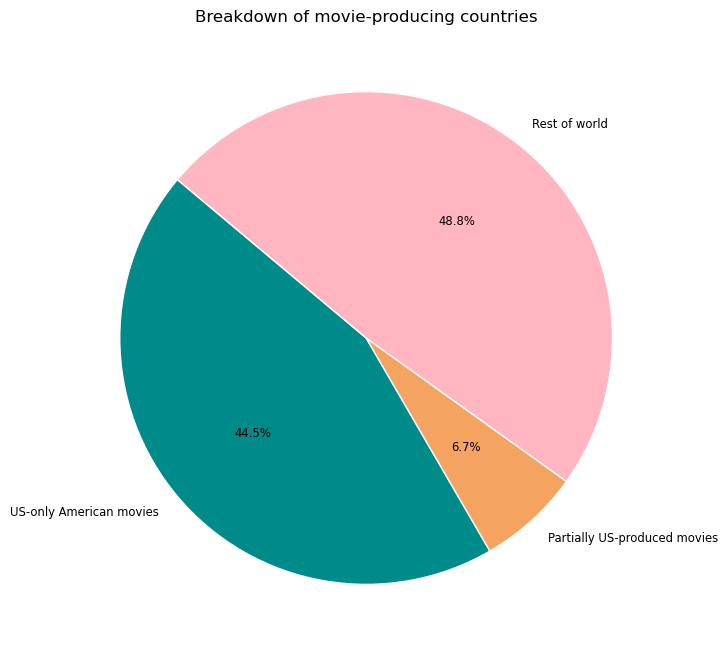

In [ ]:
total_number_movies_df = all_movies['title'].count()
# movies UNIQUELY produced in the US
total_number_US_movies = us_movies['countries'].count()
#total_number_non_US_movies = total_number_movies_df - total_number_US_movies

# US movies only PARTIALLY produced in the us
total_number_partial_US_movies = us_partially_movies['countries'].count()
#movie_mtd.countries.str.contains('United States of America').sum() - total_number_US_movies
strict_rest_world_movies = rest_world_non_US['countries'].count()
#total_number_movies_df - (total_number_partial_US_movies + total_number_US_movies)

#print(f"The unique countries' names where movies are produced are:\n{list(df_movie_metadata_CMU_IMDB['countries'].unique())}")

print(f"The total number of films in the dataset is {total_number_movies_df}.")
print(f"The total number of american movies uniquely produced in the US in the dataset is {total_number_US_movies}.")
print(f"The total number of american movies partially produced in the US in the dataset is {total_number_partial_US_movies}.")
print(f"The total number of movies strictly produced outside the US in the dataset is {strict_rest_world_movies}.")

list_numbers_movies_granular = [total_number_US_movies, total_number_partial_US_movies, strict_rest_world_movies] 

fig, ax = plt.subplots(figsize=(12, 8))
ax.pie(
    list_numbers_movies_granular,
    labels= ['US-only American movies', 'Partially US-produced movies' , 'Rest of world'],
    autopct='%1.1f%%',
    colors = ['darkcyan', 'sandybrown', 'lightpink'],
    textprops= {'size': 'smaller'},  # Adjust text size
    startangle= 140,  # Start the chart at a different angle for better spacing
    wedgeprops= {'edgecolor': 'white'}  # white separation between slices to make the pie chart more readable
)
plt.title("Breakdown of movie-producing countries")
plt.show()

Box office analysis
- One states here that column 'country' from the CMu dataset represent the country of production of the movie. (**voir si on étoffe**)

Basic stats

In [11]:
# whole dataset
basic_stats_box_office_all_movies = all_movies['box_office'].describe()
# american movies STRICTLY produced in the US
basic_stats_box_office_US = us_movies['box_office'].describe()
# american movies PARTIALLY produced in the US
basic_stats_box_office_US_partial = us_partially_movies['box_office'].describe()
# Rest of world (= Non Us movies)
basic_stats_box_office_ROW = rest_world_non_US['box_office'].describe()

dict_results = {'All movies': [basic_stats_box_office_all_movies.loc['50%'], basic_stats_box_office_all_movies.loc['mean'], basic_stats_box_office_all_movies.loc['std'], basic_stats_box_office_all_movies.loc['max'], basic_stats_box_office_all_movies.loc['min']], 
                'US-only produced': [basic_stats_box_office_US.loc['50%'], basic_stats_box_office_US.loc['mean'], basic_stats_box_office_US.loc['std'], basic_stats_box_office_US.loc['max'], basic_stats_box_office_US.loc['min']], 
                'Partially US-produced': [basic_stats_box_office_US_partial.loc['50%'], basic_stats_box_office_US_partial.loc['mean'], basic_stats_box_office_US_partial.loc['std'], basic_stats_box_office_US_partial.loc['max'], basic_stats_box_office_all_movies.loc['min']],
                'Non US produced (ROW)': [basic_stats_box_office_ROW.loc['50%'], basic_stats_box_office_ROW.loc['mean'], basic_stats_box_office_ROW.loc['std'], basic_stats_box_office_ROW.loc['max'], basic_stats_box_office_ROW.loc['min']]}

df_basic_stat_box_office = pd.DataFrame(dict_results, index = ['median (millions USD)', 'mean (millions USD)', 'std (millions USD)', 'max (millions USD)', 'min (millions USD)'])/1e6
df_basic_stat_box_office.style.format("{:.2f}") # to display only 1 decimal after the comma taking advantage of the Jupyter notebook environment

,All movies,US-only produced,Partially US-produced,Non US produced (ROW)
median (millions USD),10.70,10.65,22.75,5.23
mean (millions USD),47.48,48.12,75.02,16.64
std (millions USD),109.09,106.38,150.88,34.17
max (millions USD),2782.28,1511.76,2782.28,377.91
min (millions USD),0.01,0.01,0.01,0.01


In [12]:
print(all_movies[all_movies['box_office'] >= 2.78e+09][['title', 'release_year']])

        title  release_year
23705  Avatar        2009.0


By looking at the above data frame containing basic statistics on box office revnue, one can hihglights the following points: first, one sees that the median is around 10 millions dollars for both US-only produced and all the movies produced worlwide in the dataset. US-partially produced movies show a two times higher median. This observation is logical if one observes the maximum value of box office value. This value corresponds to the first Avatar movie (cf. above cell) and it clearly helps increasing both mean and median of US-partially produced movies. By looking at the above table, one can already mention that producing a film only partially in the US lead to higher box office revenue. Finally, the non-US produced movies generate much less box office revenue on average and looking at the median. Indeed, the median is nearly five times lower than US-partially produced movies and two times lower than US-only produced movies. For the mean, the factors are 3 and 4.75 lower for Non-US movies, respectively.

**By analyzing basic stats on box office revenue, one obtains the first clues that show the benefits in terms of box office revenue of producing movies in the US strctly or even better, producing them partially in the US.**

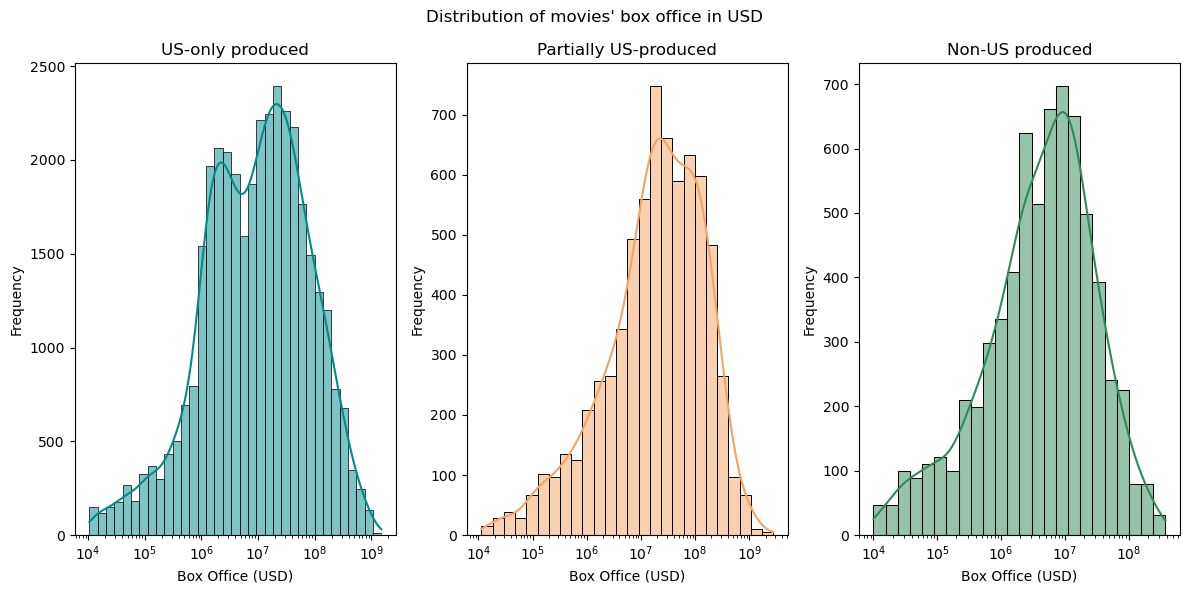

In [13]:
# First visualization of the distribution of 

fig, axes = plt.subplots(1, 3, figsize = (12,6))
# stat = 'frequency' chosen since it represent the relative frequency (proportion) of movies in each bin, scaled to sum to 1.
# And it is useful for comparing distributions with different sample sizes
sns.histplot(us_movies['box_office'], kde=True, stat='frequency', bins = 'auto', color='darkcyan', cumulative = False, log_scale= True, ax=axes[0]).set(title="US-only produced") # bins = 'auto' produces too small binsi if no log scale used
axes[0].set_xlabel("Box Office (USD)")
sns.histplot(us_partially_movies['box_office'], kde=True, stat='frequency', bins = 'auto', color='sandybrown', cumulative = False, log_scale= True, ax=axes[1]).set(title="Partially US-produced")
axes[1].set_xlabel("Box Office (USD)")
sns.histplot(rest_world_non_US['box_office'], kde=True, stat='frequency', bins = 'auto', color='seagreen', cumulative = False, log_scale= True, ax=axes[2]).set(title="Non-US produced") 
axes[2].set_xlabel("Box Office (USD)")
fig.suptitle("Distribution of movies' box office in USD") # to avoid any overlapping
fig.tight_layout()
plt.show()

Without using a log-scale, one immediately sees that the box office values in USD follow a heavy-tailed distribution. Indeed, a few films generated about one billion USD while the vast majority generated around 50 to 100 million dollars (cf. basic stats section above). Furthermore, the distribution is right-skewed. This means that the mean and standard deviation are meaningless (**chiant pour la suite, à discuter et lien avec log scale parce que je "corrige" ça dans uns sens**)
So one uses a logarithmic x-axis to better capture the different distributions. By looking at the three above charts, one observes that US movies (both only and partially produced in the US) generate box office revenue ranging between 10'00 and about 1 billion dollars. On the other hand, the movies' box office produced in the rest of the world only range between 10'000 and about 100 millions dollars. Moreover, the above plots illustrate the fact that there are more US-only american movies produced than partially US or non-Us produced movies since the freqeuncy is higher (**reprendre**).

Runtime analysis
- one recalls here the the films lasting more than 180 minutes are discarded (cf. above)

Basic stats

In [18]:
# whole dataset
basic_stats_runtime_all_movies = all_movies['runtime'].describe()
# american movies STRICTLY produced in the US
basic_stats_runtime_US = us_movies['runtime'].describe()
# american movies PARTIALLY produced in the US
basic_stats_runtime_US_partial = us_partially_movies['runtime'].describe()
# Rest of world (= Non Us movies)
basic_stats_runtime_ROW = rest_world_non_US['runtime'].describe()

dict_results = {'All movies': [basic_stats_runtime_all_movies.loc['50%'], basic_stats_runtime_all_movies.loc['mean'], basic_stats_runtime_all_movies.loc['std'], basic_stats_runtime_all_movies.loc['max'], basic_stats_runtime_all_movies.loc['min']], 
                'US-only produced': [basic_stats_runtime_US.loc['50%'], basic_stats_runtime_US.loc['mean'], basic_stats_runtime_US.loc['std'], basic_stats_runtime_US.loc['max'], basic_stats_runtime_US.loc['min']], 
                'Partially US-produced': [basic_stats_runtime_US_partial.loc['50%'], basic_stats_runtime_US_partial.loc['mean'], basic_stats_runtime_US_partial.loc['std'], basic_stats_runtime_US_partial.loc['max'], basic_stats_runtime_all_movies.loc['min']],
                'Non US produced (ROW)': [basic_stats_runtime_ROW.loc['50%'], basic_stats_runtime_ROW.loc['mean'], basic_stats_runtime_ROW.loc['std'], basic_stats_runtime_ROW.loc['max'], basic_stats_runtime_ROW.loc['min']]}

df_basic_stat_box_office = pd.DataFrame(dict_results, index = ['median (minutes)', 'mean (minutes)', 'std (minutes)', 'max (minutes)', 'min (minutes)'])
df_basic_stat_box_office.style.format("{:.1f}") # to display only 1 decimal after the comma taking advantage of the Jupyter notebook environment

,All movies,US-only produced,Partially US-produced,Non US produced (ROW)
median (minutes),93.0,100.0,104.0,107.0
mean (minutes),91.2,102.8,107.4,109.1
std (minutes),30.8,16.8,19.1,18.3
max (minutes),180.0,180.0,180.0,180.0
min (minutes),0.0,10.0,0.0,16.0


One observes that for all the different categories of production the median is located around 95 minutes. The mean is a bit higher, around 100 minutes. The standard deviation is around 30 minutes which big since some films are very short. Indeed the first movies back in the 20s were very short films lasting less than 60 minutes.

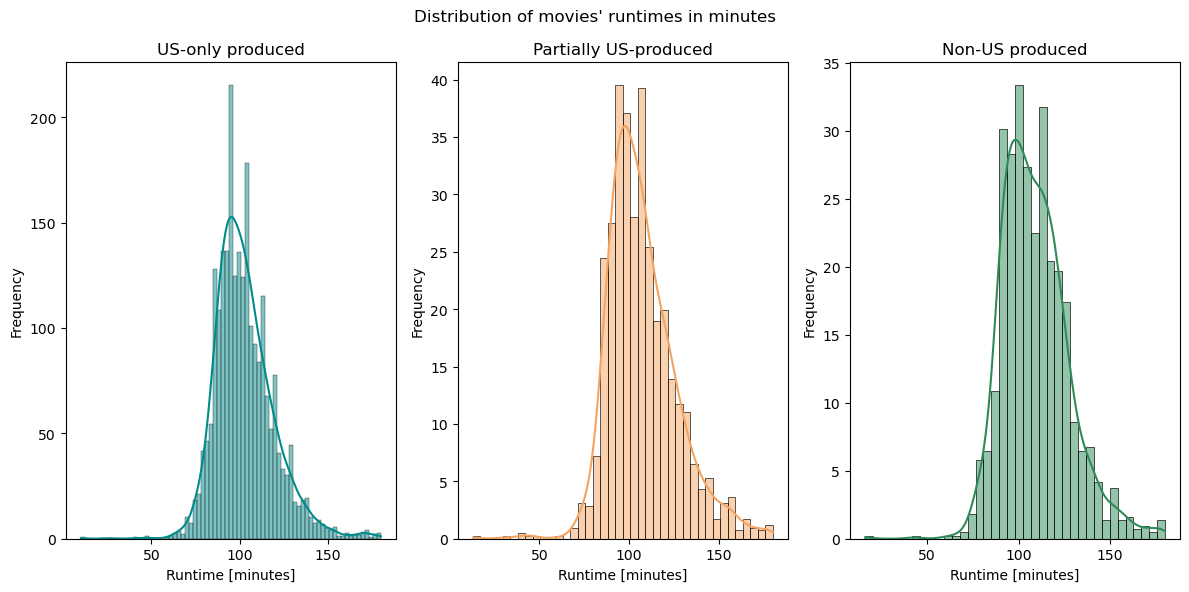

In [19]:
# First visualization

fig, axes = plt.subplots(1, 3, figsize = (12,6))
# stat = 'frequency' chosen since it represent the relative frequency (proportion) of movies in each bin, scaled to sum to 1.
# And it is useful for comparing distributions with different sample sizes
sns.histplot(us_movies['runtime'], kde=True, stat='frequency', bins = 'auto', color='darkcyan', cumulative = False, log_scale= False, ax=axes[0]).set(title="US-only produced") # bins = 'auto' produces too small binsi if no log scale used
axes[0].set_xlabel("Runtime [minutes]")
sns.histplot(us_partially_movies['runtime'], kde=True, stat='frequency', bins = 'auto', color='sandybrown', cumulative = False, log_scale= False, ax=axes[1]).set(title="Partially US-produced")
axes[1].set_xlabel("Runtime [minutes]")
sns.histplot(rest_world_non_US['runtime'], kde=True, stat='frequency', bins = 'auto', color='seagreen', cumulative = False, log_scale= False, ax=axes[2]).set(title="Non-US produced") 
axes[2].set_xlabel("Runtime [minutes]")
fig.suptitle("Distribution of movies' runtimes in minutes")
fig.tight_layout()
plt.show()

For US-only, partially-US and Non-US produced movies, the distribution seems to follow more or less a normal distribution centered around 100 minutes (1h40). Once again this is because of the silent and short the lauched the cinema industry back in the 20s-30s.

Average IMDb ratings analysis

Basic stats

In [24]:
# whole dataset
basic_stats_averageRating_all_movies = all_movies['averageRating'].describe()
# american movies STRICTLY produced in the US
basic_stats_averageRating_US = us_movies['averageRating'].describe()
# american movies PARTIALLY produced in the US
basic_stats_averageRating_US_partial = us_partially_movies['averageRating'].describe()
# Rest of world (= Non Us movies)
basic_stats_averageRating_ROW = rest_world_non_US['averageRating'].describe()

dict_results = {'All movies': [basic_stats_averageRating_all_movies.loc['50%'], basic_stats_averageRating_all_movies.loc['mean'], basic_stats_averageRating_all_movies.loc['std'], basic_stats_averageRating_all_movies.loc['max'], basic_stats_averageRating_all_movies.loc['min']], 
                'US-only produced': [basic_stats_averageRating_US.loc['50%'], basic_stats_averageRating_US.loc['mean'], basic_stats_averageRating_US.loc['std'], basic_stats_averageRating_US.loc['max'], basic_stats_averageRating_US.loc['min']], 
                'Partially US-produced': [basic_stats_averageRating_US_partial.loc['50%'], basic_stats_averageRating_US_partial.loc['mean'], basic_stats_averageRating_US_partial.loc['std'], basic_stats_averageRating_US_partial.loc['max'], basic_stats_averageRating_all_movies.loc['min']],
                'Non US produced (ROW)': [basic_stats_averageRating_ROW.loc['50%'], basic_stats_averageRating_ROW.loc['mean'], basic_stats_averageRating_ROW.loc['std'], basic_stats_averageRating_ROW.loc['max'], basic_stats_averageRating_ROW.loc['min']]}

df_basic_stat_box_office = pd.DataFrame(dict_results, index = ['median [-]', 'mean [-]', 'std [-]', 'max [-]', 'min [-]'])
df_basic_stat_box_office.style.format("{:.1f}") # to display only 1 decimal after the comma taking advantage of the Jupyter notebook environment

,All movies,US-only produced,Partially US-produced,Non US produced (ROW)
median [-],6.3,6.4,6.4,6.7
mean [-],6.2,6.3,6.3,6.6
std [-],1.0,0.9,1.0,0.9
max [-],10.0,9.3,8.9,8.5
min [-],1.4,1.7,1.4,3.2


Looking at the basic stats on average IMdb ratings, one notices that the mean and median are quite similar for all production type which indicatd that the data is not skewed and that it likely follows a normal distribution. One will verify this hypotehsis in section 1.2, *Statistical Test* (see below). The standard deviation is also similar across all production types.<br>
**To conclude, producing a movies in the US-only or partially in the US does note seems to lead to higher rating on average by the public.**

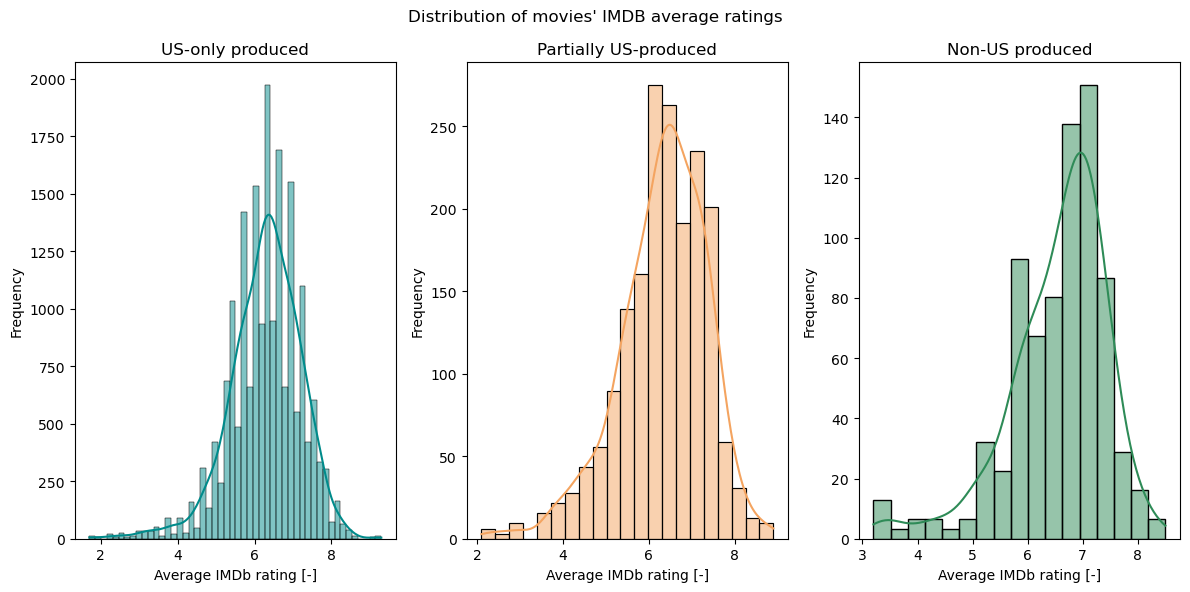

In [25]:
# First visualization

fig, axes = plt.subplots(1, 3, figsize = (12,6))
# stat = 'frequency' chosen since it represent the relative frequency (proportion) of movies in each bin, scaled to sum to 1.
# And it is useful for comparing distributions with different sample sizes
sns.histplot(us_movies['averageRating'], kde=True, stat='frequency', bins = 'auto', color='darkcyan', cumulative = False, log_scale= False, ax=axes[0]).set(title="US-only produced") # bins = 'auto' produces too small binsi if no log scale used
axes[0].set_xlabel("Average IMDb rating [-]")
sns.histplot(us_partially_movies['averageRating'], kde=True, stat='frequency', bins = 'auto', color='sandybrown', cumulative = False, log_scale= False, ax=axes[1]).set(title="Partially US-produced")
axes[1].set_xlabel("Average IMDb rating [-]")
sns.histplot(rest_world_non_US['averageRating'], kde=True, stat='frequency', bins = 'auto', color='seagreen', cumulative = False, log_scale= False, ax=axes[2]).set(title="Non-US produced") 
axes[2].set_xlabel("Average IMDb rating [-]")
fig.suptitle("Distribution of movies' IMDB average ratings")
fig.tight_layout()
plt.show()

The histogram for the average IMDb rating for US-only produced movies seems to follow a normal distribution. On the contrary, the average IMDb rating for partially US-produced and Non-US produced movies are slithly right skewed. Furthermore, as seen in the basic stats section, most of the movies ratings are located around 6 with very few ratings above 8.

#### Translations analysis

##### How to work with the 'language' column ?

Some languages do not contain the word "Language" (ie nan, different case, or just not mentionned). Hence, to count the number of translations, we choose the count the number of comma in the cells of the column 'languages'.

To get some examples of languages that do not contain the world "Language" in this colomn, please run this line : 
print(movie_mtd[movie_mtd['languages'].apply(lambda x: x.count('Language')==0 if isinstance(x, str) else True)]['languages'].unique()[:10])

Proportion of movies available at least in 2 languages:  0.12005186671233548
Proportion of movies available at least in 2 languages, but not in English:  0.032661349513137934
Proportion of movies available at least in 2 languages, including English:  0.08739051719919753
Proportion of silent movies:  0.03894896511229633
Proportion of movies available at least in English:  0.5002568870186427
Proportion of movies available only in English:  0.41286636981944513


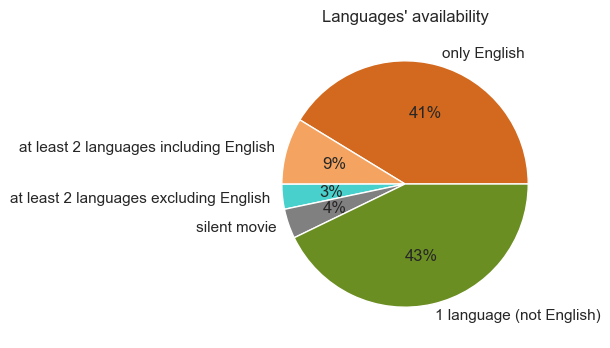

In [112]:
######################################## EXPLORATORY ANALYSIS OF THE TRANSLATIONS ####################################

#count number of movies available in at least 2 languages
def fct_2L_available(x):
    if isinstance(x, str):
        if x.count(',')>=1: #each comma separates 2 languages, so the number of languages is the number of comma +1 
            return True 
        else :
            return False
    else :
        return False

count_2L=movie_mtd['languages'].apply(lambda x:  fct_2L_available(x)).sum()
print(f'Proportion of movies available at least in 2 languages: ', count_2L/len(movie_mtd))


#count number of movies available in at least 2 languages, but not available in English
def fct(x):
    if isinstance(x, str):
        if x.count(',')>=1 and ("english language" not in x.lower()) : #each comma separates 2 languages, so the number of languages is the number of comma +1 
            return True
        else :
            return False
    else :
        return False

count_2LnotE=movie_mtd['languages'].apply(lambda x:  fct(x)).sum()
print(f'Proportion of movies available at least in 2 languages, but not in English: ', count_2LnotE/len(movie_mtd))


#count number of movies available in at least 2 languages, including English
def fct(x):
    if isinstance(x, str):
        if x.count(',')>=1 and ("english language" in x.lower()) : #each comma separates 2 languages, so the number of languages is the number of comma +1 
            return True
        else : 
            return False
    else :
        return False

count_2L_E=movie_mtd['languages'].apply(lambda x:  fct(x)).sum()
print(f'Proportion of movies available at least in 2 languages, including English: ', count_2L_E/len(movie_mtd))


#the case of silent movies : we could consider that they are available in all languages, but it is surely negligeable...
count_silent=movie_mtd['languages'].apply(lambda x: 'silent film' in x.lower() if isinstance(x, str) else False).sum()
print(f'Proportion of silent movies: ', count_silent/len(movie_mtd))
#they are not that negligeable...


#proportion of movies available in English

#calculate proportion of movies available in English
def english_available(x):
    if isinstance(x, str):
        if ("english language" in x.lower()) :
            return True
        else :
            return False
    else :
        return False

count_E = movie_mtd['languages'].apply(lambda x: english_available(x)).sum()  
print(f'Proportion of movies available at least in English: ', count_E/len(movie_mtd))


#proportion of movies available only in English
def fct(x):
    if isinstance(x, str):
        if ("english language" in x.lower()) and x.count(',')==0 : 
            return 1
        else :
            return 0
    else :
        return 0
count_onlyE=movie_mtd['languages'].apply(lambda x:  fct(x)).sum()
print(f'Proportion of movies available only in English: ', count_onlyE/len(movie_mtd))

############################################# PIE CHARTS ############################################### 
rest=100-count_onlyE*100/len(movie_mtd)- count_2LnotE*100/len(movie_mtd)- (count_2L*100/len(movie_mtd)-count_2LnotE*100/len(movie_mtd))-count_silent*100/len(movie_mtd)

data = [count_onlyE*100/len(movie_mtd),  count_2L*100/len(movie_mtd)-count_2LnotE*100/len(movie_mtd), count_2LnotE*100/len(movie_mtd),count_silent*100/len(movie_mtd), rest] 
keys = ['only English', 'at least 2 languages including English', 'at least 2 languages excluding English', 'silent movie', '1 language (not English)'] 
plt.figure(figsize=(4, 4))
sns.set_theme(style="darkgrid")
plt.title("Languages' availability")
# plot a pie chart
plt.pie(data, labels=keys, colors=['chocolate','sandybrown','mediumturquoise','grey','olivedrab'], autopct='%.0f%%')  
plt.show() 



The calculated p-value is 4.1333356288440356e-10.
The difference in means is statistically significant for an alpha-level of 0.05.


C:\Users\Claire PINSON\AppData\Local\Temp\ipykernel_33396\1416902651.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.boxplot(movie_mtd, x='english available', y='box_office', palette='pastel')
C:\Users\Claire PINSON\AppData\Local\Temp\ipykernel_33396\1416902651.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['No','Yes'])


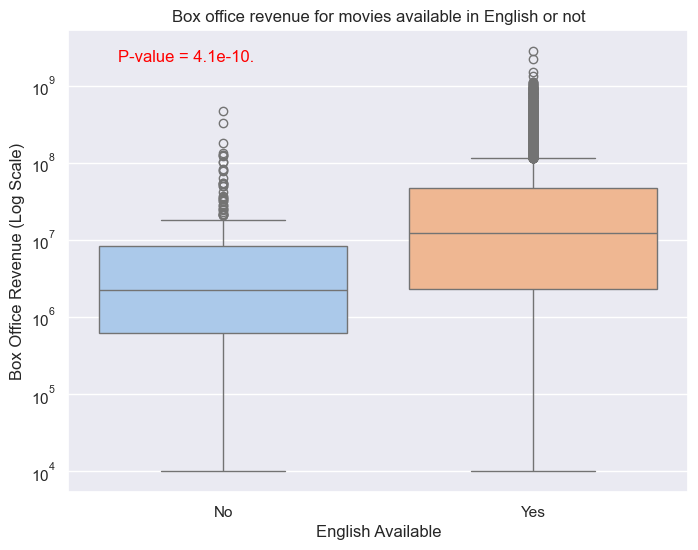

In [106]:
#how different is the bow office revenue for movies available in English vs not available in English ? t-test for significance
#box plots
def fct(x):
    if isinstance(x, str):
        if "english"  in x.lower() : #each comma separates 2 languages, so the number of languages is the number of comma +1 
            return 1
    else :
        return 0
movie_mtd['english available']=movie_mtd['languages'].apply(lambda x: fct(x))

######################################## Statistical test ##############################################""
#are the means significantly different ?
alpha=0.05
statistic, p_value=ttest_ind(movie_mtd[movie_mtd['english available']==1]['box_office'].dropna(), movie_mtd[movie_mtd['english available']==0 ]['box_office'].dropna())
print(f'The calculated p-value is {p_value}.')
if p_value<alpha :
    print(f'The difference in means is statistically significant for an alpha-level of {alpha}.')
else :
    print(f'The difference in means is NOT statistically significant for an alpha-level of {alpha}.')

####################sns.boxplot à regarder ########### (serie data visualisation)
plt.figure(figsize=(8, 6))
sns.set_theme(style="darkgrid")
ax=sns.boxplot(movie_mtd, x='english available', y='box_office', palette='pastel')
#oxplot=movie_mtd.boxplot('box_office', by='english available')
plt.yscale('log') #because otherwise the outliers are overwhelming in the plot
plt.title('Box office revenue for movies available in English or not')
plt.suptitle('') #to remove the automatic subtitle of .boxplot
ax.set_xticklabels(['No','Yes'])
plt.xlabel('English Available')
plt.ylabel('Box Office Revenue (Log Scale)')
#the x and y positions are in the images coordinates (log scale x linear scale)
ax.text(0.1, 2*10**9, f'P-value = {p_value:.1e}.', ha='right', fontsize=12, color='red')

plt.show()


In [108]:
#we will consider separetly the movies produced only by the US from movies produced only partially by the US
#isolate them in datasets
movie_mtd_strict_us=movie_mtd[movie_mtd['countries']=='United States of America']
movie_mtd_incl_us=movie_mtd[movie_mtd['countries'].str.contains('United States of America', na=False) & movie_mtd['countries'].str.contains(',', na=False) ]


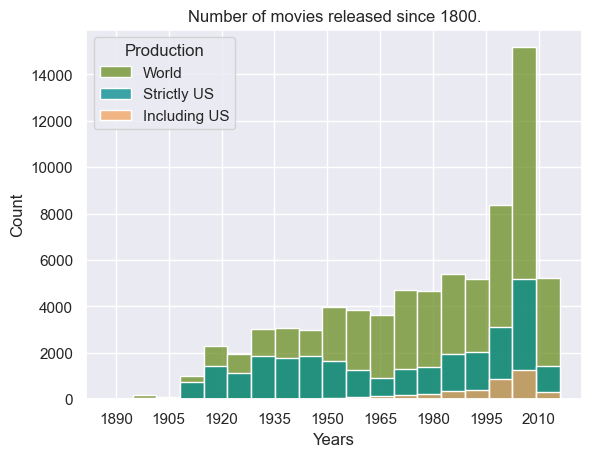

The last bar is low... this is probably because the last date of the dataset does not reach the upper bound of that bin.


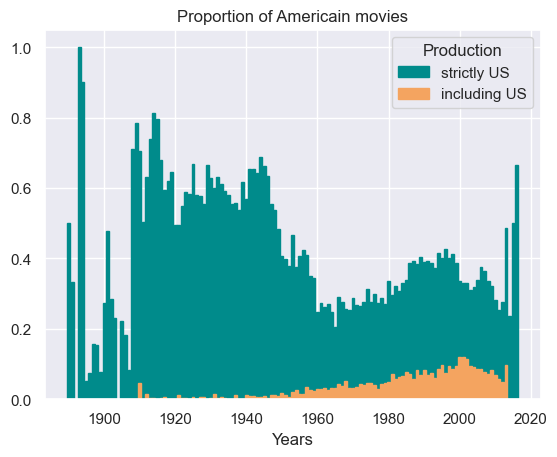

In [116]:
#distribution of released movies over time :
num_bins=20
bin_edges = np.linspace(min(movie_mtd['release_year']), max(movie_mtd['release_year']), num_bins)


fig, ax = plt.subplots()
sns.histplot(data=movie_mtd, x='release_year', bins=bin_edges, color='olivedrab', label='World')
sns.histplot(data=movie_mtd_strict_us, x='release_year', bins=bin_edges, color='darkcyan', label='Strictly US' )
sns.histplot(data=movie_mtd_incl_us, x='release_year', bins=bin_edges, color='sandybrown', label='Including US' )


ax.xaxis.set_major_locator(MaxNLocator(10))
plt.title('Number of movies released since 1800.')
plt.xlabel('Years')
plt.legend(title='Production')
plt.show()

print('The last bar is low... this is probably because the last date of the dataset does not reach the upper bound of that bin.')

# Plot of the evolution of the proportion of americain movies over time
# pareil pour les autres langages (établir si des langages sont devenus 'populaires' au fil du temps)

nbins=np.arange(min(movie_mtd['release_year']), max(movie_mtd['release_year'])+1)

prop_incl_us=(movie_mtd_incl_us.groupby('release_year')['wiki_movie_ID'].count()/movie_mtd.groupby('release_year')['wiki_movie_ID'].count())
prop_strict_us=(movie_mtd_strict_us.groupby('release_year')['wiki_movie_ID'].count()/movie_mtd.groupby('release_year')['wiki_movie_ID'].count())

fig, ax = plt.subplots()
plt.bar(nbins, prop_strict_us, width=0.8, color = 'darkcyan', edgecolor='darkcyan', label='strictly US')
plt.bar(nbins, prop_incl_us, width=0.8, color = 'sandybrown', edgecolor='sandybrown', label='including US')
plt.title('Proportion of Americain movies')
plt.legend(title='Production')
plt.xlabel('Years')
plt.show()

In [110]:
############################ TRANSLATIONS AMONG GENRES #############################
    
#the column of genre can contain many genres, to do so we explode the dataset according to the genres
movies_mtd_genre_exploded=movie_mtd.copy()
movies_mtd_genre_exploded['genres_IMDB'] = movies_mtd_genre_exploded['genres_IMDB'].str.split(',') #creates a list with the genres

#we create a row for each genre, so each movie genre is duplicated to have one genre/row
movies_mtd_genre_exploded = movies_mtd_genre_exploded.explode('genres_IMDB')
#reset index to avoid problems latter with the groupby
movies_mtd_genre_exploded = movies_mtd_genre_exploded.reset_index(drop=True)

#count the number of traductions for each genre among all movies
#each comma separates 2 languages, so the number of languages is the number of comma +1, the number of translations is the number of comma

def language_count(x):
    if isinstance(x, str):
        return  x.count(',')     
    else :
        return False
    
movies_mtd_genre_exploded['translations_count']=movies_mtd_genre_exploded['languages'].apply(lambda x: language_count(x))

######################## Isolate us movies from this dataset ##################

#strictly aericain movies
movies_mtd_strict_us_genre_exploded=movies_mtd_genre_exploded[movies_mtd_genre_exploded['countries'].apply(lambda x: x.lower()=='united states of america' if isinstance(x, str) else False)]
#movies produced by US but not only
movies_mtd_incl_us_genre_exploded=movies_mtd_genre_exploded[movies_mtd_genre_exploded['countries'].str.contains('United States of America', na=False) & movie_mtd['countries'].str.contains(',', na=False)]

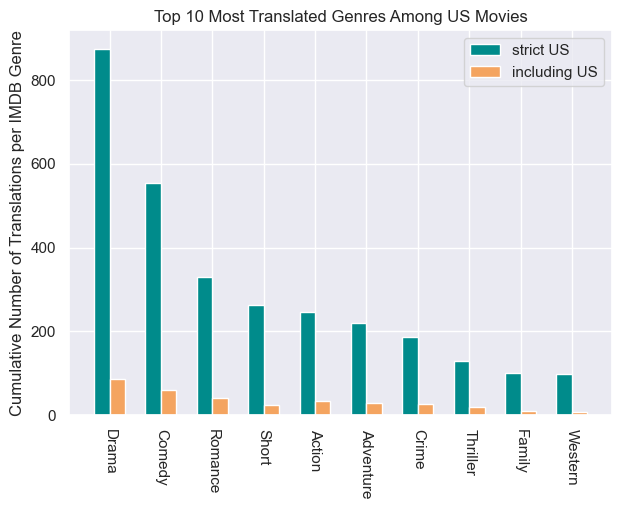

In [111]:
#basé sur les films produits aux US, est-ce que le genre le plus traduit (vers toutes langues confondues) a évolué ? 

#quel est le genre qui cumule le plus de traductions parmi les films américain ?
#parmi les films américains, calculer le nombre de traductions par film puis groupby genre de film et sum()
#la colonne 'countries' est tjrs des strings


groupby_genre_translation_strict_us=movies_mtd_strict_us_genre_exploded['translations_count'].groupby(movies_mtd_strict_us_genre_exploded['genres_IMDB']).sum()
groupby_genre_translation_incl_us=movies_mtd_incl_us_genre_exploded['translations_count'].groupby(movies_mtd_incl_us_genre_exploded['genres_IMDB']).sum()


#parameters
width = 0.3
n=10

#top 10 genres for movies strictly produced by US
top_genres_strict_us = groupby_genre_translation_strict_us.sort_values(ascending=False).head(n)
#we want to reorder the genres of movies partially produced by the US to match that previous top 10 genres (of movies strictly produced by US)
#to do so, we reindex 
corresponding_genres_incl_us = groupby_genre_translation_incl_us.reindex(top_genres_strict_us.index)

######################################## Plotting ######################################
fig, ax = plt.subplots(figsize=(7, 5))

# Plot the bars side by side
ax.bar(np.arange(n) - width/2, top_genres_strict_us, width=width, label='strict US', color='darkcyan')
ax.bar(np.arange(n) + width/2, corresponding_genres_incl_us, width=width, label='including US', color='sandybrown')

# Add labels and titles
ax.legend()
ax.set_title('Top 10 Most Translated Genres Among US Movies')
ax.set_ylabel('Cumulative Number of Translations per IMDB Genre')
ax.set_xticks(np.arange(n))
ax.set_xticklabels(groupby_genre_translation_strict_us.sort_values(ascending=False).head(n).index,rotation=-90)

plt.show()

     release_year  wiki_movie_ID
0          1899.0              1
1          1900.0              3
2          1901.0              2
3          1905.0              1
4          1906.0              1
..            ...            ...
106        2008.0            301
107        2009.0            291
108        2010.0            249
109        2011.0            225
110        2012.0            108

[111 rows x 2 columns]


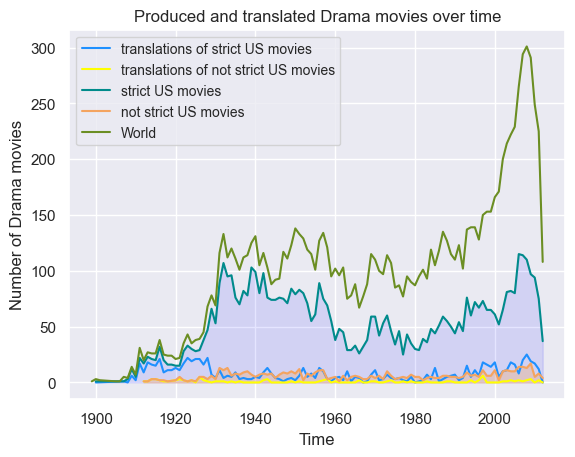

In [124]:
#what is the evolution of top1 (DRAMA movies) translated over time ?

'''#create a dataset exploded by genre but for every movie, not only us movies (as above)
movies_mtd_genre_exploded=movie_mtd.copy()
movies_mtd_genre_exploded['genres_IMDB'] = movies_mtd_genre_exploded['genres_IMDB'].str.split(',') #creates a list with the genres
#we create a row for each genre, so each movie genre is duplicated to have one genre/row
movies_mtd_genre_exploded = movies_mtd_genre_exploded.explode('genres_IMDB')
#reset index to avoid problems latter with the groupby
movies_mtd_genre_exploded = movies_mtd_genre_exploded.reset_index(drop=True)'''

def language_count(x):
    if isinstance(x, str):
        return  x.count(',')     
    else :
        return False
movies_mtd_genre_exploded['translations_count']=movies_mtd_genre_exploded['languages'].apply(lambda x: language_count(x))


###########################################################################################

#count number of DRAMA movies produced per year in the world
#.reset_index() to use in the sns.linepolt()
drama_produced_total = movies_mtd_genre_exploded[movies_mtd_genre_exploded['genres_IMDB']=='Drama']['wiki_movie_ID'].groupby(movies_mtd_genre_exploded['release_year']).count().reset_index()
print(drama_produced_total)


#count number of DRAMA movies produced per year in the US (strict/including)
#.reset_index() to use in the sns.linepolt()
drama_produced_strict_us = movies_mtd_strict_us_genre_exploded[movies_mtd_strict_us_genre_exploded['genres_IMDB']=='Drama']['wiki_movie_ID'].groupby(movies_mtd_strict_us_genre_exploded['release_year']).count().reset_index()
drama_produced_incl_us = movies_mtd_incl_us_genre_exploded[movies_mtd_incl_us_genre_exploded['genres_IMDB']=='Drama']['wiki_movie_ID'].groupby(movies_mtd_incl_us_genre_exploded['release_year']).count().reset_index()

#Evolution of translations of US Drama movies (strict/including)
drama_translated_strict_us = movies_mtd_strict_us_genre_exploded[movies_mtd_strict_us_genre_exploded['genres_IMDB']=='Drama']['translations_count'].groupby(movies_mtd_strict_us_genre_exploded['release_year']).sum().reset_index()
drama_translated_incl_us = movies_mtd_incl_us_genre_exploded[movies_mtd_incl_us_genre_exploded['genres_IMDB']=='Drama']['translations_count'].groupby(movies_mtd_incl_us_genre_exploded['release_year']).sum().reset_index()



################################################# PLOT ##################################################
sns.set_theme(style="darkgrid")

# Plot Number of produced Drama movies in the US & in the World
sns.lineplot(data=drama_translated_strict_us, x='release_year', y='translations_count', label="translations of strict US movies", color='dodgerblue') #use y='wiki_movie_ID' because we did the groupby on this colomn before counting on the groupby
sns.lineplot(data=drama_translated_incl_us, x='release_year', y='translations_count', label="translations of not strict US movies", color='yellow') #use y='wiki_movie_ID' because we did the groupby on this colomn before counting on the groupby

sns.lineplot(data=drama_produced_strict_us, x='release_year', y='wiki_movie_ID', label="strict US movies", color='darkcyan') #use y='wiki_movie_ID' because we did the groupby on this colomn before counting on the groupby
sns.lineplot(data=drama_produced_incl_us, x='release_year', y='wiki_movie_ID', label="not strict US movies", color='sandybrown') #use y='wiki_movie_ID' because we did the groupby on this colomn before counting on the groupby

sns.lineplot(data=drama_produced_total, x='release_year', y='wiki_movie_ID', label='World', color='olivedrab') #use y='wiki_movie_ID' because we did the groupby on this colomn before counting on the groupby
plt.fill_between(drama_produced_strict_us['release_year'], drama_produced_strict_us['wiki_movie_ID'] , color='blue', alpha=0.1)
plt.fill_between(drama_produced_incl_us['release_year'], drama_produced_incl_us['wiki_movie_ID'] , color='sandybrown', alpha=0.3)
#plt.fill_between(drama_translated_us['release_year'], drama_translated_us['translations_count'] , color='darkcyan', alpha=0.1)

plt.xlabel("Time")
#plt.yscale('log')
plt.ylabel("Number of Drama movies")
plt.title("Produced and translated Drama movies over time")
plt.legend(loc='upper left', fontsize=10, title_fontsize='12')
plt.show()


### 1.2 Exploratory analysis of the dataset according to our research questions
- main plots 
- organiser en sous section suivnat les research questions (à voir)
- rajouter des cells en markdown qui expliquent nos plots
- **essayer de faire des liens avec nos recherches questions dans nos textes pour voir la cohérence de l'ensemble**

Box office timeseries analysis

Investigating the NaN values in the *box_office* column

In [14]:
nan_number_all_movies_box_office = all_movies['box_office'].isna().sum(axis = 0)
nan_number_US_movies_box_office = us_movies['box_office'].isna().sum(axis = 0)
nan_number_partially_US_movies_box_office = us_partially_movies['box_office'].isna().sum(axis = 0)
nan_number_ROW_box_office = rest_world_non_US['box_office'].isna().sum(axis = 0)
print(f"Proportion of NaN box office values in the whole dataset: {(nan_number_all_movies_box_office/len(all_movies))*100:.2f} %.")
print(f"Proportion of NaN box office values for US-only produced movies : {(nan_number_US_movies_box_office/len(us_movies))*100:.2f} %.")
print(f"Proportion of NaN box office values for US-only produced movies : {(nan_number_partially_US_movies_box_office/len(us_partially_movies))*100:.2f} %.")
print(f"Proportion of NaN box office values for non-US (ROW) produced movies : {(nan_number_ROW_box_office/len(rest_world_non_US))*100:.2f} %.")

Proportion of NaN box office values in the whole dataset: 86.38 %.
Proportion of NaN box office values for US-only produced movies : 78.65 %.
Proportion of NaN box office values for US-only produced movies : 62.66 %.
Proportion of NaN box office values for non-US (ROW) produced movies : 95.36 %.


One can immediately see that the proportion of Nan values is **very high** so one **chooses to drop the lines containing NaN values for the timeseries analysis**. See the below cell for more details.

In [15]:
# Drop NaN values ONLY (using the parameter subset) from the 'box_office'& 'release_year' since we are doing time series
rest_world_non_US = rest_world_non_US.dropna(subset=['box_office', 'release_year'])
us_movies = us_movies.dropna(subset=['box_office', 'release_year'])
us_partially_movies = us_partially_movies.dropna(subset=['box_office', 'release_year'])

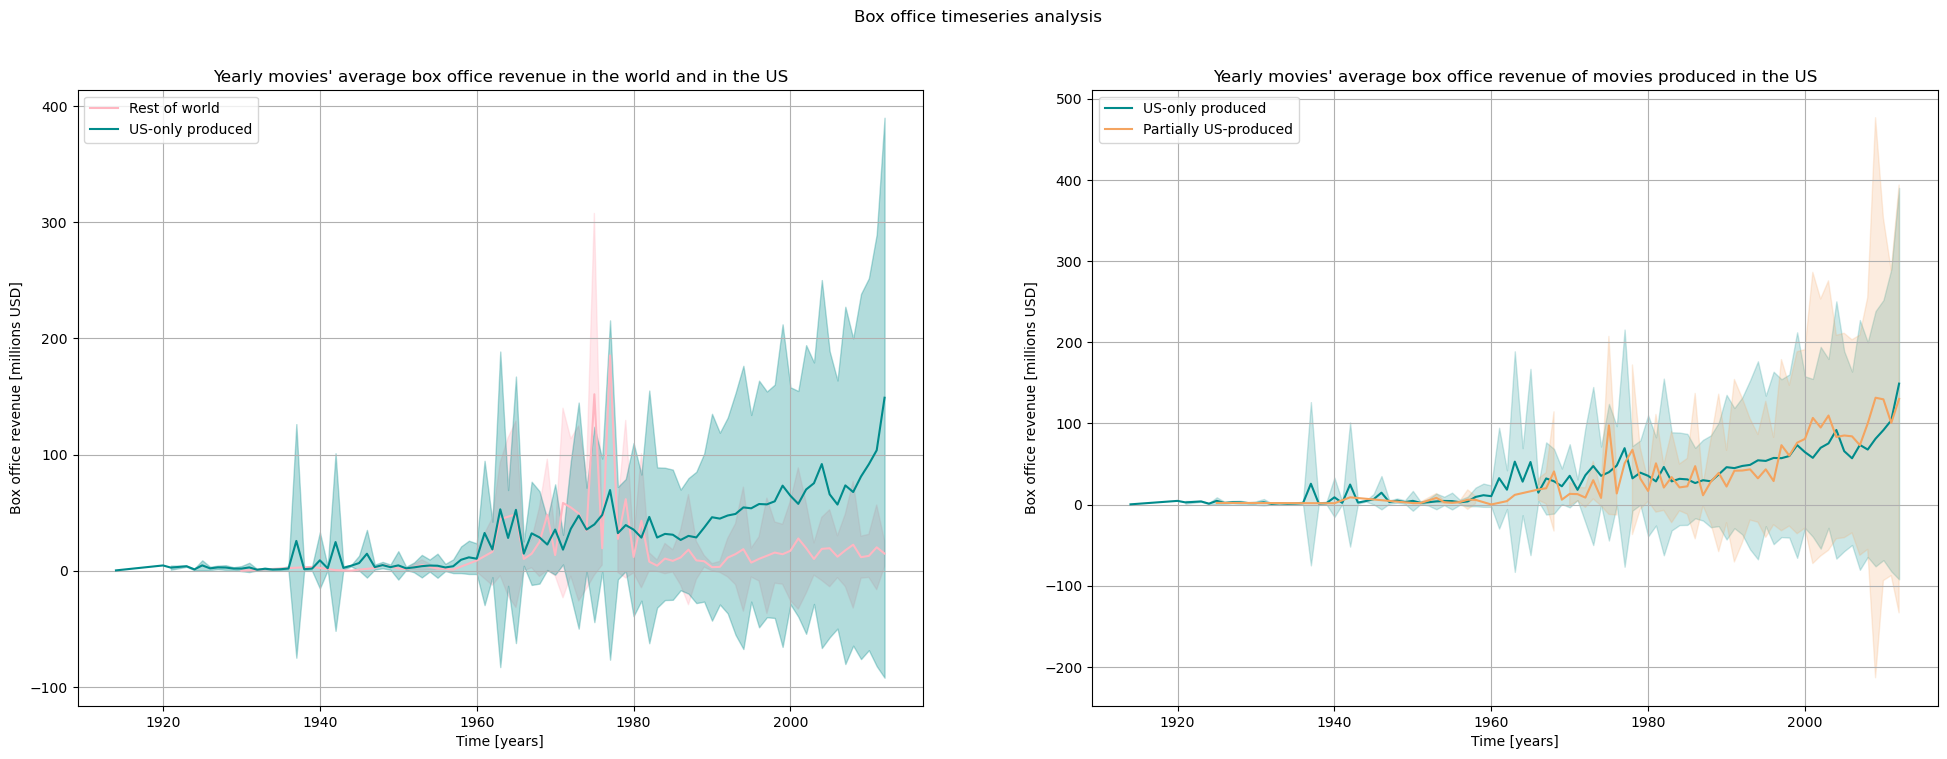

In [16]:
# average box office revenue for all movies per year world wide
avrg_ROW_box_office_per_year = rest_world_non_US.groupby('release_year')['box_office'].mean()
std_ROW_box_office_per_year = rest_world_non_US.groupby('release_year')['box_office'].std()

# average box office revenue for all movies per year in the US (movies STRICTLY produced in the US)
avrg_us_box_office_per_year = us_movies.groupby('release_year')['box_office'].mean()
std_us_box_office_per_year = us_movies.groupby('release_year')['box_office'].std()

# average box office revenue for all movies per year in the US (movies PARTIALLY produced in the US)
avrg_us_partial_box_office_per_year = us_partially_movies.groupby('release_year')['box_office'].mean()
std_us_partial_box_office_per_year = us_partially_movies.groupby('release_year')['box_office'].std()

fig, ax = plt.subplots(nrows = 1, ncols= 2, figsize = (24,8))
ax[0].plot(rest_world_non_US['release_year'].drop_duplicates().sort_values(), avrg_ROW_box_office_per_year/(1e6), label = 'Rest of world', color = 'lightpink')
ax[0].fill_between(rest_world_non_US['release_year'].drop_duplicates().sort_values(), y1= (avrg_ROW_box_office_per_year - std_ROW_box_office_per_year)/(1e6), y2 = (avrg_ROW_box_office_per_year + std_ROW_box_office_per_year)/(1e6), linestyle='-', color='lightpink', alpha=0.3)
ax[0].plot(us_movies['release_year'].drop_duplicates().sort_values(), avrg_us_box_office_per_year/(1e6), label = 'US-only produced', color = 'darkcyan')
ax[0].fill_between(us_movies['release_year'].drop_duplicates().sort_values(), y1= (avrg_us_box_office_per_year - std_us_box_office_per_year)/(1e6), y2 = (avrg_us_box_office_per_year + std_us_box_office_per_year)/(1e6), linestyle='-', color='darkcyan', alpha=0.3)
ax[0].set_title("Yearly movies' average box office revenue in the world and in the US")
ax[0].set_xlabel("Time [years]")
ax[0].set_ylabel("Box office revenue [millions USD]")
ax[0].legend()
ax[0].grid()

ax[1].plot(us_movies['release_year'].drop_duplicates().sort_values(), avrg_us_box_office_per_year/(1e6), label = 'US-only produced', color='darkcyan')
ax[1].fill_between(us_movies['release_year'].drop_duplicates().sort_values(), y1= (avrg_us_box_office_per_year - std_us_box_office_per_year)/(1e6), y2 = (avrg_us_box_office_per_year + std_us_box_office_per_year)/(1e6), linestyle='-', color='darkcyan', alpha=0.2)
# us partial
ax[1].plot(us_partially_movies['release_year'].drop_duplicates().sort_values(), avrg_us_partial_box_office_per_year/(1e6), label = 'Partially US-produced', color = 'sandybrown')
ax[1].fill_between(us_partially_movies['release_year'].drop_duplicates().sort_values(), y1= (avrg_us_partial_box_office_per_year - std_us_partial_box_office_per_year)/(1e6), y2 = (avrg_us_partial_box_office_per_year + std_us_partial_box_office_per_year)/(1e6), linestyle='-', color='sandybrown', alpha=0.2)
ax[1].set_title("Yearly movies' average box office revenue of movies produced in the US")
ax[1].set_xlabel("Time [years]")
ax[1].set_ylabel("Box office revenue [millions USD]")
ax[1].legend()
ax[1].grid()
fig.suptitle("Box office timeseries analysis")
plt.show()

The timeseries of yearly box office revenue is shown in the two above plots. First, one sees that from 1920 to 1940, movies were only produced in the US. This matches more or less with the creation of the first Hollywood studios (1913)(**besoin citer ?**). Then, by comparing the yearly average box office revenue between US-only and non-US produced movies, one clearly sees that the average yearly box office is higher between 1920 and 1965 and in the period 1980-2016. Between 1965 and 1980, the US-only produced movies generated less movies per year than the ROW movies (**chercher une explication**). Finally, the plot shows an increasing trend in yearly average box office revenue for US-only produced movies. For the movies produced in the rest of the world, a decreasing trend is to be seen until 1990. After this date, the yearly average box ofice revenue increases again but more slowly.<br>
<br>
Moving on to the right plot, one notices that first until the 60s, US-only produced movies were generating higher revenue on average yearly. After 1960, there is no clear distinction between average yearly box offices values for US-only and partially-US produced movies. However, since 2000 it seems that producing a film only partially in the US is beneficial in terms of yearly average box office revenues. This can be explained by the fact that nowadays, movies are generally not only produced in one country since many virtual effects companies are taking contracts worldwide. Furthermore, it is sometimes cheaper to produce a movies partially out of the US because labor is cheaper.<br>
<br>
Finally, one highlights the fact that the errors intervalls (filled with semi-transparent color) are quite important. This comes from the fact that the standard deviation is bigger than the mean for many movies (cf. section *Basic Stats*). This can be explained by the fact that the box office distribution is heavy tailed, meaning that there are some movies that gerenerate a very high revenue as *Avatar* for example (cf. above) which "pulls up" other box office values. Movies with really small box office revenus as depicted in the 20s to the 60s are also responsible for this huge errorbars since they "pulls down" other box office values. **One can therefore question the relevance of using the mean and standard deviation for theses plots**. The problem is that the median is not suited to create such plots. (**DISCUTER**)

Runtime timeseries analysis

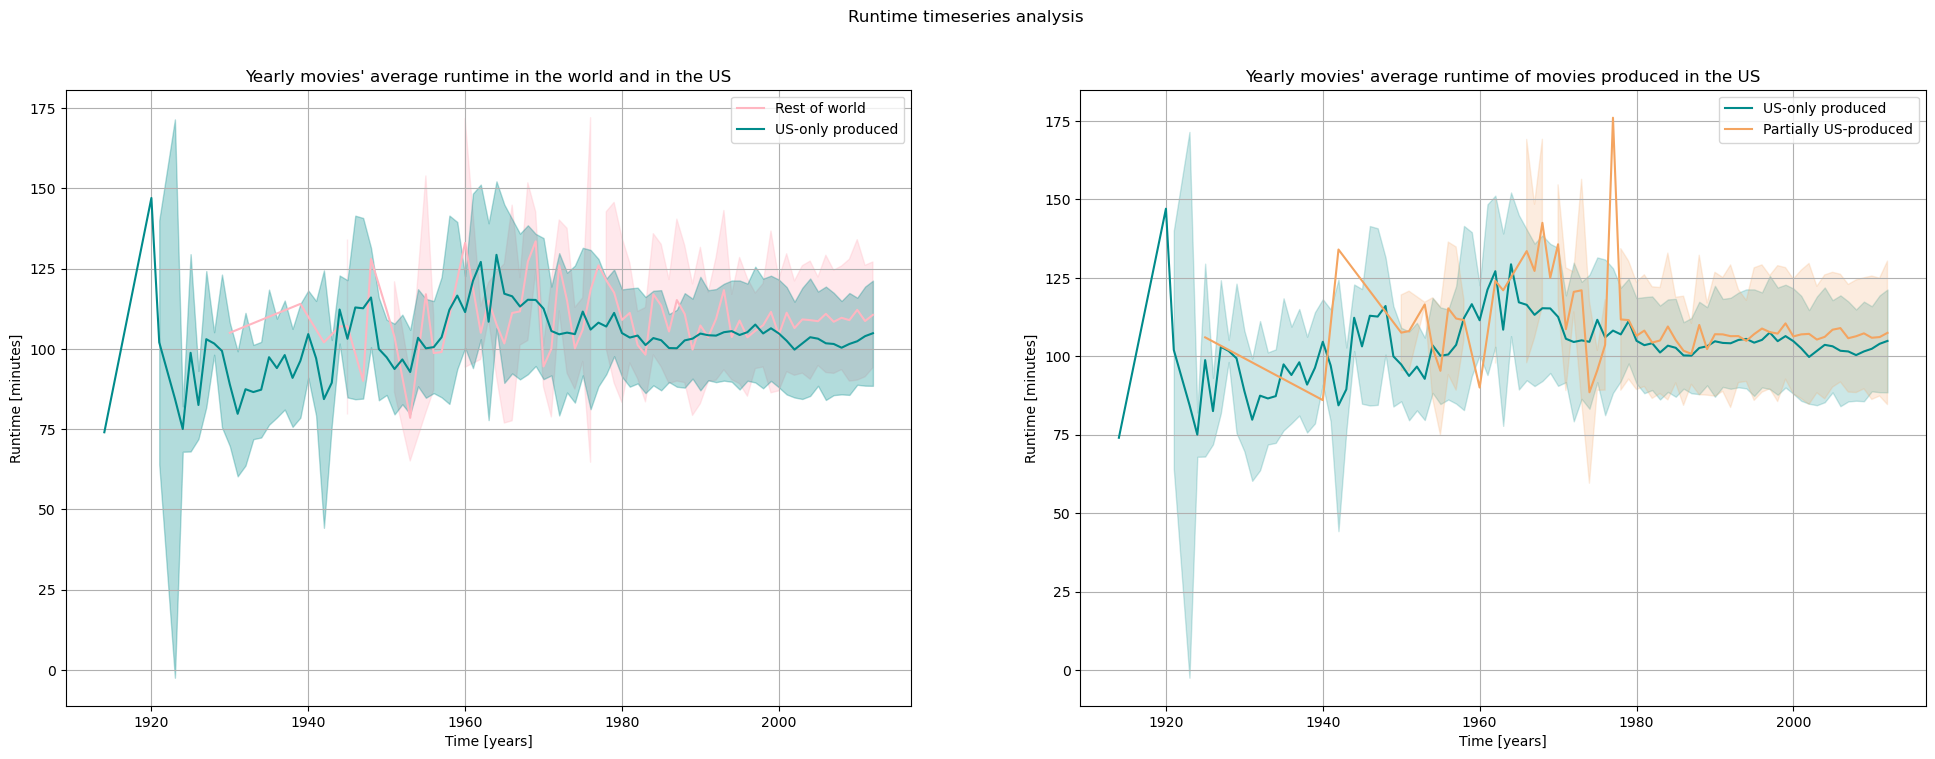

In [20]:
# average box office revenue for all movies per year world wide
avrg_ROW_runtime_per_year = rest_world_non_US.groupby('release_year')['runtime'].mean()
std_ROW_runtime_per_year = rest_world_non_US.groupby('release_year')['runtime'].std()

# average box office revenue for all movies per year in the US (movies STRICTLY produced in the US)
avrg_us_runtime_per_year = us_movies.groupby('release_year')['runtime'].mean()
std_us_runtime_per_year = us_movies.groupby('release_year')['runtime'].std()

# average box office revenue for all movies per year in the US (movies PARTIALLY produced in the US)
avrg_us_partial_runtime_per_year = us_partially_movies.groupby('release_year')['runtime'].mean()
std_us_partial_runtime_per_year = us_partially_movies.groupby('release_year')['runtime'].std()

fig, ax = plt.subplots(nrows = 1, ncols= 2, figsize = (24,8))
ax[0].plot(rest_world_non_US['release_year'].drop_duplicates().sort_values(), avrg_ROW_runtime_per_year, label = 'Rest of world', color = 'lightpink') # [:-1] to remove the single nan from the release year column
ax[0].fill_between(rest_world_non_US['release_year'].drop_duplicates().sort_values(), y1= avrg_ROW_runtime_per_year - std_ROW_runtime_per_year, y2 = avrg_ROW_runtime_per_year + std_ROW_runtime_per_year, linestyle='-', color='lightpink', alpha=0.3)
ax[0].plot(us_movies['release_year'].drop_duplicates().sort_values(), avrg_us_runtime_per_year, label = 'US-only produced', color = 'darkcyan')
ax[0].fill_between(us_movies['release_year'].drop_duplicates().sort_values(), y1= avrg_us_runtime_per_year - std_us_runtime_per_year, y2 = avrg_us_runtime_per_year + std_us_runtime_per_year, linestyle='-', color='darkcyan', alpha=0.3)
ax[0].set_title("Yearly movies' average runtime in the world and in the US")
ax[0].set_xlabel("Time [years]")
ax[0].set_ylabel("Runtime [minutes]")
ax[0].legend()
ax[0].grid()

ax[1].plot(us_movies['release_year'].drop_duplicates().sort_values(), avrg_us_runtime_per_year, label = 'US-only produced', color='darkcyan')
ax[1].fill_between(us_movies['release_year'].drop_duplicates().sort_values(), y1= avrg_us_runtime_per_year - std_us_runtime_per_year, y2 = avrg_us_runtime_per_year + std_us_runtime_per_year, linestyle='-', color='darkcyan', alpha=0.2)
# us partial
ax[1].plot(us_partially_movies['release_year'].drop_duplicates().sort_values(), avrg_us_partial_runtime_per_year, label = 'Partially US-produced', color = 'sandybrown')
ax[1].fill_between(us_partially_movies['release_year'].drop_duplicates().sort_values(), y1= avrg_us_partial_runtime_per_year - std_us_partial_runtime_per_year, y2 = avrg_us_partial_runtime_per_year + std_us_partial_runtime_per_year, linestyle='-', color='sandybrown', alpha=0.2)
ax[1].set_title("Yearly movies' average runtime of movies produced in the US")
ax[1].set_xlabel("Time [years]")
ax[1].set_ylabel("Runtime [minutes]")
ax[1].legend()
ax[1].grid()
fig.suptitle("Runtime timeseries analysis")
plt.show()

One starts with the left plot. Each timeseries shows qui a lot of variation. On average, Non-US produced movies seems to last a bit more than US-only produced movies. The standard deviation is important but not as big as in the box office timeseries where the standard deviation was higher than the mean.<br>
<br>
Moving on to the right plot, partially US-produced movies seems also to last a bit longer than US-only produced movies.<br>
<br>
For both plots, one notices big peaks that are probably due to long films (i.e. lasting about 3 hours) (**more investigation needed**) <br>
<br>
These plots are usefiul here to give the reader a common sense about how the runtime analysis evolved through time. The more detailed part comes in the next cells below.

Pairwise Analysis: Box Office, Runtime, and IMDb Rating by Production Type

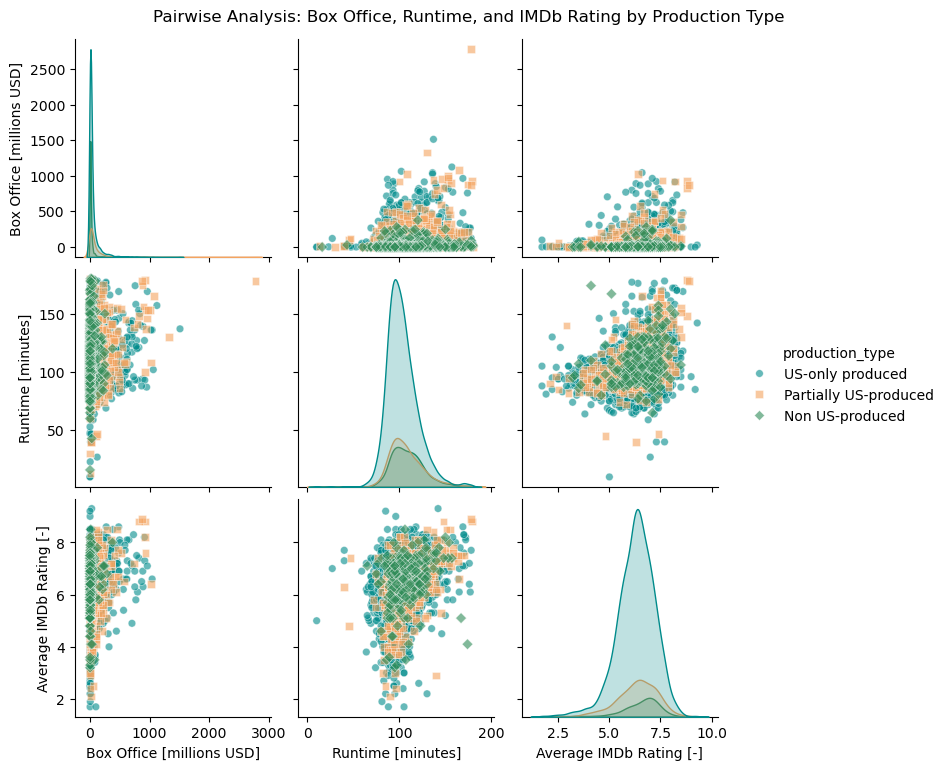

In [21]:
# Select only relevant columns for analysis and add a 'production_type' column
us_movies_subset = us_movies[['box_office', 'runtime', 'averageRating']].copy()
us_movies_subset['production_type'] = 'US-only produced'

us_partially_movies_subset = us_partially_movies[['box_office', 'runtime', 'averageRating']].copy()
us_partially_movies_subset['production_type'] = 'Partially US-produced'

rest_world_non_US_subset = rest_world_non_US[['box_office', 'runtime', 'averageRating']].copy()
rest_world_non_US_subset['production_type'] = 'Non US-produced'

# Scale box office values to millions for better readability
us_movies_subset['box_office'] = us_movies_subset['box_office'] / 1e6
us_partially_movies_subset['box_office'] = us_partially_movies_subset['box_office'] / 1e6
rest_world_non_US_subset['box_office'] = rest_world_non_US_subset['box_office'] / 1e6

# Combine the subsets
combined_df = pd.concat([us_movies_subset, us_partially_movies_subset, rest_world_non_US_subset], ignore_index=True)

# rename the columns of the new df to have clearer axes
combined_df = combined_df.rename(columns={
    'box_office': 'Box Office [millions USD]',
    'averageRating': 'Average IMDb Rating [-]',
    'runtime': 'Runtime [minutes]'
})

# Use sns.pairplot for visualizing relationships
sns.pairplot(
    combined_df,
    hue='production_type',
    #kind = 'reg',
    #plot_kws={'scatter_kws': {'alpha': 0.6, 's': 40}},
    markers=["o", "s", "D"],
    plot_kws= {'alpha': 0.6, 's': 30}, # 's' is the size of the scatter point and alpah their transparency
    palette={'US-only produced': 'darkcyan', 'Partially US-produced': 'sandybrown', 'Non US-produced': 'seagreen'}
)

# Main title
plt.suptitle("Pairwise Analysis: Box Office, Runtime, and IMDb Rating by Production Type", y=1.02)
plt.show()

The above figure provides a pairwise analysis between box office, runtime, and average IMDb ratings by Production Type. On the diagonal, one finds the kernel density function for each production type. Then, one only looks at the three plots at the lower left corner of the figure. Indeed, the 3 plots in the top right corner are similar but with the axes reversed. <br>
<br>
First one looks at the runtime vs the box office: one observes that most of the movies in the dataset have a value of box office between 50 and 100 millions USD. There is no clear trend/correlation between runtime and box office, meaning that longer lasting movies does not necessarly means that the box office revenue is higher. <br>
<br>
Moving on to the IMDb ratings versus the box office, no clear trend is to be observed once again. Indeed, having a higher public rating does not guarantee that the box office officerevenue generated will be higher. <br>
<br>
The last plot illustrates the average IMDb rating versus the runtime. Once again, no clear trend is oberservable since most of the points are aggregated around 100 minutes (coherent with the basic stats done on runtime above) for different average rating. <br>
<br>
**To conclude, the following plots are not sufficient to provide clear insights about if the US-only and partially US-produced movies lead to better ratings hwen compared with box office revenue and runtime. One will thus implement statistical test in the below cells to investigate further**

Statistical test

In [30]:
# Hypothesis stating
# H0: null hypothesis: there is NO significant link between the two variables of interest, namely bewteen box_office and IMDB ratings, runtime and IMDb rating & box vs runtime
# HA: alternative hypothesis: there is a significant link between the two variables of interest, namely bewteen box_office and IMDB ratings, runtime and IMDb rating & box vs runtime

ALPHA = 0.05 # significance level for the statistical tests

df_production_list = [us_movies, us_partially_movies, rest_world_non_US]
names_list = ["US-only produced", "US partially produced", "Non-US produced"]
list_spearman_production_box_IMDB = []
list_spearman_production_runtime_IMDB = []
list_spearman_production_box_runtime = []
for df in df_production_list:
    # spearman r correlation coeff chosen since box office distribution is not normal but heavy-tailed and because all values are continuous.
    stat_box_IMDB, pvalue_box_IMDB = spearmanr(df['box_office'],df['averageRating'], nan_policy='omit')
    stat_runtime_IMDB, pvalue_runtime_IMDB = spearmanr(df['runtime'],df['averageRating'], nan_policy='omit') 
    stat_box_runtime, pvalue_box_runtime = spearmanr(df['box_office'],df['runtime'], nan_policy='omit')
    list_spearman_production_box_IMDB.append(pvalue_box_IMDB)
    list_spearman_production_runtime_IMDB.append(pvalue_runtime_IMDB)
    list_spearman_production_box_runtime.append(pvalue_box_runtime)

# Correlation investigation between box office revenue & average IMDb rating
for name, pval in zip(names_list, list_spearman_production_box_IMDB):
    if pval < ALPHA:
        print(f"The is a significant link between box office revenue and average IMDb ratings for {name} movies. We can confidently reject the null Hypothesis H0 ({pval} < {ALPHA}).") # The test statistic is {stat}
    else:
        print(f"Impossible to reject the null hypothesis H0. Nothing can be concluded betwen the link between box office revenue and average IMDb ratings for {name} movies ({pval} > {ALPHA}).")
print("\n") # to improve readability

# Correlation investigation between runtime & average IMDb rating
for name, pval in zip(names_list, list_spearman_production_runtime_IMDB):
    if pval < ALPHA:
        print(f"The is a significant link between runtime and average IMDb ratings for {name} movies. We can confidently reject the null Hypothesis H0 ({pval} < {ALPHA}).") # The test statistic is {stat}
    else:
        print(f"Impossible to reject the null hypothesis H0. Nothing can be concluded betwen the link between runtime and average IMDb ratings for {name} movies ({pval} > {ALPHA}).")
print("\n") 

# Correlation investigation between box office revenue & runtime
for name, pval in zip(names_list, list_spearman_production_box_runtime):
    if pval < ALPHA:
        print(f"The is a significant link between box office revenue and runtime for {name} movies. We can confidently reject the null Hypothesis H0 ({pval} < {ALPHA}).") # The test statistic is {stat}
    else:
        print(f"Impossible to reject the null hypothesis H0. Nothing can be concluded betwen the link between box office revenue and runtime for {name} movies ({pval} > {ALPHA}).")

The is a significant link between box office revenue and average IMDb ratings for US-only produced movies. We can confidently reject the null Hypothesis H0 (7.34426211385612e-16 < 0.05).
The is a significant link between box office revenue and average IMDb ratings for US partially produced movies. We can confidently reject the null Hypothesis H0 (2.0477782725656203e-07 < 0.05).
The is a significant link between box office revenue and average IMDb ratings for Non-US produced movies. We can confidently reject the null Hypothesis H0 (0.0005259459372126205 < 0.05).


The is a significant link between runtime and average IMDb ratings for US-only produced movies. We can confidently reject the null Hypothesis H0 (2.979322192582868e-59 < 0.05).
The is a significant link between runtime and average IMDb ratings for US partially produced movies. We can confidently reject the null Hypothesis H0 (1.961896682826424e-34 < 0.05).
The is a significant link between runtime and average IMDb ratings for 

**Contredit complétement le plot d'avant avec tous les subplots ??** ou sinon le plot ne permet pas de voir grand chose plus tôt. Parce que peut y avoir une non.lin relationship qui n'est pas clairement visible dans le plot. **A DISCUTER**

# 2. Character metadata enriched with wikipedia actor's nationality

### 2.1 General information about the dataset
- pie charts and print statements + basics stats

The total number of US movies is 30016 (36.72% of the total)
The total number of US actors in US movies is 137929


C:\Users\gerry\AppData\Local\Temp\ipykernel_11188\2319293302.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_movies['US_nationality'] = (us_movies['nationality'] == 'American')


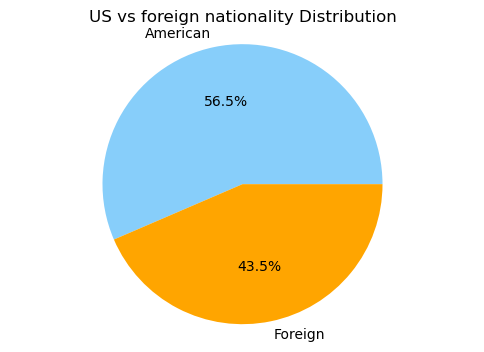

In [25]:
# Number of American movies (as movies created in the United States of America, entirely or partly)


us_movies = actor_mtd.loc[actor_mtd['countries'].str.contains('United States of America', case=False, na=False)]
world_movies = actor_mtd.loc[~actor_mtd['countries'].str.contains('United States of America', case=False, na=False)]
us_movies_shape = us_movies['wiki_movie_ID'].unique()
print(f'The total number of US movies is {len(us_movies_shape)} ({len(us_movies_shape) / movie_mtd.shape[0] * 100:.2f}% of the total)')

us_actors = us_movies.loc[us_movies['nationality'] == 'American']
foreign_actors = us_movies.loc[us_movies['nationality'] == 'Other']
print(f'The total number of US actors in US movies is {us_actors.shape[0]}')

# Visualize the pie chart
us_movies['US_nationality'] = (us_movies['nationality'] == 'American')
nationality_counts = us_movies['US_nationality'].value_counts()
plt.figure(figsize=(6, 4))
plt.pie(nationality_counts, labels=['American','Foreign'], autopct='%1.1f%%', colors=['lightskyblue','orange'])
plt.title('US vs foreign nationality Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is a circle
plt.show()

### 2.2 Exploratory analysis of the dataset according to our research questions
- main plots 
- organiser en sous section suivnat les research questions (à voir)
- rajouter des cells en markdown qui expliquent nos plots
- **essayer de faire des liens avec nos recherches questions dans nos textes pour voir la cohérence de l'ensemble**

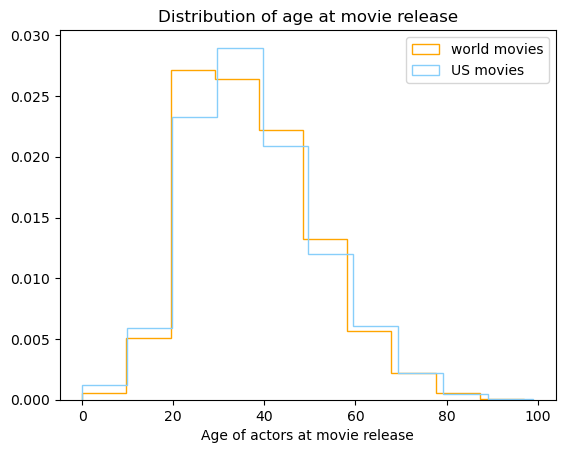

In [33]:
# See if actors in US movies have early carrers

us_movies = us_movies[us_movies['age_at_release'] < 100]
world_movies = world_movies[world_movies['age_at_release']<100]
age_us = us_movies['age_at_release'].dropna(how='any')
age_world = world_movies['age_at_release'].dropna(how='any')
plt.hist(age_world, color = 'orange', density = True, histtype='step', label='world movies')
plt.hist(age_us, color = 'lightskyblue', density = True,
         histtype='step', label= 'US movies') # If we want to better compare the 2 use density = True
plt.xlabel("Age of actors at movie release")
plt.title("Distribution of age at movie release")
plt.legend()

The minimum age for Foreign actors is 0.0 and for the US actors is 0.0


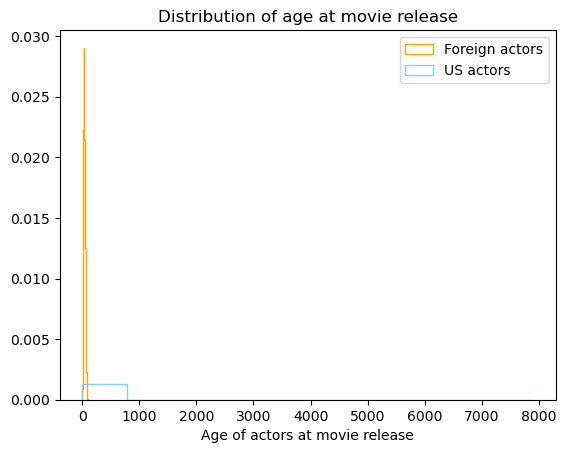

In [34]:
# See impact on US vs foreign actors - histogram

age_us_actors = us_actors['age_at_release'].to_list()
age_foreign_actors = foreign_actors['age_at_release'].to_list()
plt.hist(age_foreign_actors, color = 'orange', density = True, histtype='step', label='Foreign actors')
plt.hist(age_us_actors, color = 'lightskyblue', density = True, histtype='step', label= 'US actors') # If we want to better compare the 2 use density = True
plt.xlabel("Age of actors at movie release")
plt.title("Distribution of age at movie release")
plt.legend()

print(f'The minimum age for Foreign actors is {min(age_foreign_actors)} and for the US actors is {min(age_us_actors)}')

In [ ]:
# Box plot

age_us_actors_cleaned = [age for age in age_us_actors if not np.isnan(age)]
age_foreign_actors_cleaned = [age for age in age_foreign_actors if not np.isnan(age)]
data = [age_us_actors_cleaned, age_foreign_actors_cleaned]
plt.figure(figsize=(10, 6))
plt.boxplot(data, labels=name_list)
plt.title('Age Distribution of U.S. Actors vs Foreign Actors')
plt.ylabel('Age')
plt.show()

In [ ]:
# Definition of 'early career' is < 16/18 years?

for i, actors in enumerate([age_foreign_actors,age_us_actors]):
    early_career = (len([x for x in actors if x < 18.0]) / len(actors)) * 100
    print(f"The percentage of early career for {name_list[i]} actors is {early_career:.3f} %")

In [ ]:
# See if for American actors it is easier to act in famous movies

# Select famous movies
famous_movie_df = us_movies.sort_values('Revenue', ascending = False)
len_revenue = int(len(famous_movie_df) * 0.1)
top_10_percent_movies = famous_movie_df.head(len_revenue)
top_10_percent_movies
print(top_10_percent_movies['Actor_name'])

In [ ]:
# See the percentage of US and foreign actors
us_actors_fam = top_10_percent_movies.loc[top_10_percent_movies['Actor_name'].isin(us_actors['Actor_name'].to_list())]
age_us_fam_actors = us_actors_fam['Age'].mean()
foreign_actors_fam = top_10_percent_movies.loc[top_10_percent_movies['Actor_name'].isin(foreign_actors['Actor_name'].to_list())]
age_foreign_fam_actors = foreign_actors_fam['Age'].mean()
print(f'The mean age of the us actors acting in famous movies is {age_us_fam_actors:.3f} while for the foreign actors is {age_foreign_fam_actors:.3f}')

fam_counts = [len(us_actors_fam['Actor_name'].unique()),len(foreign_actors_fam['Actor_name'].unique())]
print(fam_counts) # NOTE: doesn't have repetitions of the same actor if in more famous movies

plt.figure(figsize=(6, 4))
plt.pie(fam_counts, labels=['American','Foreign'], autopct='%1.1f%%', colors=['lightskyblue','orange'])
plt.title('US vs foreign actors in famous American movies')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is a circle.
plt.show()

In [ ]:
# Plot the revenue based on the age for the two groups

us_revenue_by_age = us_actors.groupby('Age')['Revenue'].mean().reset_index()
foreign_revenue_by_age = foreign_actors.groupby('Age')['Revenue'].mean().reset_index()

# Too messy, divide in age groups
plt.figure(figsize=(10, 6))
bins = range(0, 101, 10)
labels = [f'{i}-{i+9}' for i in bins[:-1]]  # Create labels for bins

us_actors['Age Group'] = pd.cut(us_actors['Age'], bins=bins, labels=labels, right=False)
us_revenue_by_age = us_actors.groupby('Age Group')['Revenue'].mean().reset_index()

# Bin the ages into 10-year groups for Foreign actors
foreign_actors['Age Group'] = pd.cut(foreign_actors['Age'], bins=bins, labels=labels, right=False)
foreign_revenue_by_age = foreign_actors.groupby('Age Group')['Revenue'].mean().reset_index()

plt.plot(us_revenue_by_age['Age Group'], us_revenue_by_age['Revenue'], marker='o', label='U.S. Actors', color='lightblue')
plt.plot(foreign_revenue_by_age['Age Group'], foreign_revenue_by_age['Revenue'], marker='o', label='Foreign Actors', color='orange')

# Adding titles and labels
plt.title('Revenue Trend by Actor Age')
plt.xlabel('Age')
plt.ylabel('Average Revenue')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

In [ ]:
gender_counts_us = us_movies.groupby(['US_nationality', 'Gender']).size().unstack(fill_value=0)
gender_percentages_us = gender_counts_us.div(gender_counts_us.sum(axis=1), axis=0) * 100
ax = gender_percentages_us.plot(kind='bar', stacked=True, color=['lightcoral', 'skyblue'], figsize=(20,6))
ax.set_xlabel('Nationality')
ax.set_title('Gender distribution of actors in American movies')
ax.set_xticklabels(name_list, rotation = 0)

In [ ]:
us_revenue_by_age_gend = us_actors.groupby(['Age Group', 'Gender'])['Revenue'].mean().reset_index()
foreign_revenue_by_age_gend = foreign_actors.groupby(['Age Group', 'Gender'])['Revenue'].mean().reset_index()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plotting for U.S. Actors
sns.barplot(data=us_revenue_by_age_gend, x='Age Group', y='Revenue', hue='Gender', palette=['lightcoral', 'skyblue'], ax=axes[0])
axes[0].set_title('Average Revenue by Age Group and Gender for U.S. Actors')
axes[0].set_xlabel('Age Group')
axes[0].set_ylim(0,4.0*1e8)
axes[0].set_ylabel('Average Revenue')
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(title='Gender')

# Plotting for Foreign Actors
sns.barplot(data=foreign_revenue_by_age_gend, x='Age Group', y='Revenue', hue='Gender', palette=['lightcoral', 'skyblue'], ax=axes[1])
axes[1].set_title('Average Revenue by Age Group and Gender for Foreign Actors')
axes[1].set_xlabel('Age Group')
axes[1].set_ylim(0,4.0*1e8)
axes[1].set_ylabel('Average Revenue')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(title='Gender')

# Adjust layout
plt.tight_layout()
plt.show()# To see if during th eyears there was a change in revenue in the 2 groups
# Year is the year of movie release

# First, delete the NaNs
us_actors['Year'] = us_actors['Year'].apply(lambda x: int(x)) # Years are in the form of str (maybe to modify at the beginning)
foreign_actors['Year'] = foreign_actors['Year'].apply(lambda x: int(x))

us_revenue_by_year = us_actors.groupby('Year')['Revenue'].mean().reset_index()
foreign_revenue_by_year = foreign_actors.groupby('Year')['Revenue'].mean().reset_index()

# Too messy, divide in age groups
plt.figure(figsize=(10, 6))
bins = range(1955, 2015, 10) # I checked before for min and max
labels = [f'{i}-{i+9}' for i in bins[:-1]]  # Create labels for bins

us_actors['Year Group'] = pd.cut(us_actors['Year'], bins=bins, labels=labels, right=False)
us_revenue_by_year = us_actors.groupby('Year Group')['Revenue'].mean().reset_index()

# Bin the ages into 10-year groups for Foreign actors
foreign_actors['Year Group'] = pd.cut(foreign_actors['Year'], bins=bins, labels=labels, right=False)
foreign_revenue_by_year = foreign_actors.groupby('Year Group')['Revenue'].mean().reset_index()

plt.plot(us_revenue_by_year['Year Group'], us_revenue_by_year['Revenue'], marker='o', label='U.S. Actors', color='lightblue')
plt.plot(foreign_revenue_by_year['Year Group'], foreign_revenue_by_year['Revenue'], marker='o', label='Foreign Actors', color='orange')

# Adding titles and labels
plt.title('Revenue Trend by release Year')
plt.xlabel('Year')
plt.ylabel('Average Revenue')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()